# Quick start

- To check data and model if it preditcs or not.
- This is only for intent dataset
- Model implemented in for 8640 data samples after filtering

# 1)- Import Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pickle
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [3]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

In [4]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


# 2)- Loading Data

In [5]:
data=pd.read_pickle('file_clean_intent.pkl')

In [6]:
data.dep.nunique()

30

In [7]:
counts=data['dep'].value_counts()
df = data.loc[data['dep'].isin(counts.index[counts > 150])]

In [8]:
print(data.shape)
print(df.shape)

(9477, 4)
(8640, 4)


In [9]:
df.dep.nunique()

10

In [10]:
myfeat=["Order management","product complaints - products (Reklamation Produkte)","Software/Webshop/App",
        "Shipping issues","Customer feedback","ShareWithSaal","Payment (Bezahlung)",
        "product complaints - colours (Reklamation Farben)","Product (Produkt)","Marketing"]

### 2.1 Data Clean

In [11]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['clean'] = df['firstmessage'].apply(clean_text)

### 2.2.Train-Test

In [12]:
train_size = int(len(df) * 0.70)
train_posts = df[['clean'][:train_size]]
train_tags = df[['dep'][:train_size]]

test_posts = df[['clean'][train_size:]]
test_tags = df[['dep'][train_size:]]

In [13]:
print(train_posts.shape)

(8640, 1)


In [14]:
type(train_posts)

pandas.core.frame.DataFrame

In [15]:
train_posts.head(2)

,clean
0,helloi tried apply voucher order received mail...
1,hi tracking number please thank youkind regard...


### 2.3.Vectorize

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tf_vectorizer = TfidfVectorizer(min_df=5,stop_words='english')
tfidf_vec = tf_vectorizer.fit_transform(df.clean.values)
labels=df.dep

In [17]:
print(type(tfidf_vec))

<class 'scipy.sparse.csr.csr_matrix'>


In [18]:
tfidf_vec.shape

(8640, 7036)

In [20]:
pd.DataFrame(tfidf_vec.toarray(), columns=tf_vectorizer.get_feature_names()).head()

,00,000,0000,0001,01,02,03,04,0483,05,...,zvolil,zvolila,zvolit,zwart,zwizku,zwrot,zwrotn,zwrotu,zysk,zznam
0,0.043012,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.059614,0.059924,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.4.train-test split

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tfidf_vec, labels, random_state=42,test_size=0.33)

### 2.5.encode label feature

In [22]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train_ohe = encoder.transform(y_train) 
y_test_ohe = encoder.transform(y_test)

In [23]:
num_classes = np.max(y_train_ohe) + 1 #strings start from 0 index. To count them from 1-10
y_train = utils.to_categorical(y_train_ohe, num_classes)
y_test = utils.to_categorical(y_test_ohe, num_classes)

In [24]:
y_train[:5]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

# 3-Keras Model

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l2, l1

In [26]:
# parameters
num_input=x_train.shape[1]
num_output=labels.nunique()
epochs=10
batch_size=32

In [27]:
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=num_input))
model.add(Dense(units=num_output, activation='softmax'))
# model.add(Activation("sigmoid"))

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               703700    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 704,710
Trainable params: 704,710
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 5209 samples, validate on 579 samples
Epoch 1/10
5209/5209 [==============================] - 1s 241us/step - loss: 1.6920 - accuracy: 0.5452 - val_loss: 1.3931 - val_accuracy: 0.5630
Epoch 2/10
5209/5209 [==============================] - 1s 226us/step - loss: 1.2690 - accuracy: 0.5953 - val_loss: 1.2226 - val_accuracy: 0.6252
Epoch 3/10
5209/5209 [==============================] - 1s 228us/step - loss: 0.9843 - accuracy: 0.6775 - val_loss: 1.1060 - val_accuracy: 0.6805
Epoch 4/10
5209/5209 [==============================] - 1s 232us/step - loss: 0.7339 - accuracy: 0.7652 - val_loss: 1.0624 - val_accuracy: 0.6753
Epoch 5/10
5209/5209 [==============================] - 1s 234us/step - loss: 0.5571 - accuracy: 0.8385 - val_loss: 1.0669 - val_accuracy: 0.6788
Epoch 6/10
5209/5209 [==============================] - 1s 223us/step - loss: 0.4443 - accuracy: 0.8787 - val_loss: 1.0963 - val_accuracy: 0.6684
Epoch 7/10
5209/5209 [==============================] - 1s 226us/step - loss:

### 3.1.Evaluate Model

In [30]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

2852/2852 [==============================] - 0s 56us/step
Test accuracy: 0.6195651888847351


### 3.2.probability distribution

In [31]:
y_test_pred = model.predict(x_test)

In [32]:
print(y_test_pred.shape)

(2852, 10)


In [33]:
y_test_pred[:5]

array([[3.43780518e-02, 9.23575368e-04, 6.78394377e-01, 1.08105328e-03,
        4.80635185e-03, 6.51673228e-03, 1.55153871e-01, 4.15020715e-03,
        1.25740776e-02, 1.02021664e-01],
       [8.66177306e-03, 5.28178585e-04, 8.71340632e-01, 5.01949806e-03,
        1.45068124e-03, 3.00558168e-04, 1.13561088e-02, 4.40452136e-02,
        2.24994887e-02, 3.47978249e-02],
       [8.39464366e-02, 1.05833530e-03, 7.66656339e-01, 1.50009533e-02,
        2.90802517e-03, 2.73674820e-03, 5.28871035e-03, 1.50193297e-03,
        4.47114073e-02, 7.61910975e-02],
       [5.43553056e-03, 1.89408791e-04, 5.67120373e-01, 8.84038105e-04,
        2.08026245e-02, 6.31356903e-04, 1.42132211e-03, 3.97493422e-01,
        1.72342593e-03, 4.29847045e-03],
       [3.08567464e-01, 3.65596116e-02, 7.98415951e-03, 4.79612092e-04,
        1.41733997e-02, 2.15199351e-01, 1.77371630e-03, 3.74386579e-01,
        3.27902474e-02, 8.08583014e-03]], dtype=float32)

### 3.3.out_of_sample data

In [34]:
test_case = tf_vectorizer.transform(["I really like your products"])
model.predict(test_case.todense())

array([[0.05400248, 0.06229569, 0.26908863, 0.00704312, 0.00743419,
        0.00357599, 0.10366168, 0.01631426, 0.26278865, 0.2137953 ]],
      dtype=float32)

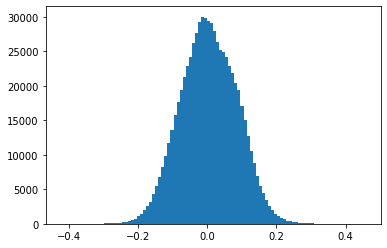

In [35]:
plt.hist(model.get_weights()[0].ravel(),100)
plt.show()

In [36]:
# weights at each step of neural network
model.weights

[<tf.Variable 'dense_1/kernel:0' shape=(7036, 100) dtype=float32, numpy=
 array([[-0.1130499 , -0.1162539 , -0.06811291, ..., -0.05497916,
          0.02835547,  0.02840912],
        [ 0.03040057, -0.05357662, -0.07437281, ...,  0.03737554,
          0.01598111, -0.05987131],
        [ 0.02162195,  0.0382107 ,  0.03317291, ..., -0.01211195,
         -0.01288501,  0.05575055],
        ...,
        [-0.03167736, -0.01859612,  0.08380631, ...,  0.03341443,
          0.03419185,  0.06911598],
        [-0.00119529,  0.00929184,  0.05871768, ...,  0.00033961,
          0.03636322, -0.0464431 ],
        [ 0.06625377,  0.02942654, -0.05737194, ..., -0.06828072,
         -0.04517774, -0.09841111]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(100,) dtype=float32, numpy=
 array([0.1148205 , 0.028911  , 0.12470996, 0.11618247, 0.10419334,
        0.11017519, 0.12679985, 0.07280851, 0.05492295, 0.2039909 ,
        0.12287208, 0.20477846, 0.12561722, 0.12540022, 0.05682994,
        0.0998

# END OF NOTEBOOK